In [ ]:
# Problem Statement     : Classify different types of flowers 

# Solution Proposal     : Developing and Deploying a Deep Learning CNN model to Classify the 104 types of flowers using Kaggle compitation data .

# Solution outcome      : After proper data preprocessing and using  VGG19 model (Transfer Learning) the accuracy achieved is ::: ==  98 % 

# Solution explaination : The Solution mainly consists of two parts : 
#                     
#                          1) Data Preprocessing 
#                          2) Selecting and Developing an appropriate model 
#                          3) Training and Testing of the model on the data 
#                          



# STEP 1 : DATA PREPROCESSING 



In [ ]:
# STEP 1 : DATA PREPROCESSING 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

from google.colab import files
files.upload() #this will prompt  to update the json

!pip install -q kaggle
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
!kaggle datasets download -d ianmoone0617/flower-goggle-tpu-classification 


 98% 258M/264M [00:01<00:00, 175MB/s]
100% 264M/264M [00:01<00:00, 165MB/s]


In [ ]:

import os
os.chdir('/content')  #change dir


!mkdir flower_data  #create a directory 

!unzip -q flower-goggle-tpu-classification.zip -d flower_data # unzip the data 

In [ ]:
# B) Understanding the data 

In [ ]:
##   IMPORTS :::


import os 
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")


In [ ]:
# lets check the data 

os.chdir('/content/flower_data')

os.listdir('/content/flower_data/') # to list the files in the directory 

['flower_tpu', 'flowers_idx.csv', 'flowers_label.csv']

In [ ]:


flowers_idx = pd.read_csv("/content/flower_data/flowers_idx.csv")

flowers_label = pd.read_csv("/content/flower_data/flowers_label.csv")


In [ ]:

# Group the dataframe according to the flower type 
flowers = flowers_idx.groupby(flowers_idx["flower_cls"]) 

flowers.head()

,id,flower_cls
0,7486,cape flower
1,9454,cape flower
2,6974,cape flower
3,4739,cape flower
4,8783,cape flower
...,...,...
12493,8242,windflower
12494,11772,windflower
12495,8782,windflower
12496,11333,windflower


In [ ]:
#  Understanding the number of datapoints for each example 

data = dict()
for mg in flowers:

  data[mg[0]] = mg[1]
 
 
l = [len(data[key]) for key in data.keys()]

for v in data.keys():
  print(len(data[v]))
  break

print(l)

print("the maximum examples of one type of flower is ::  "  ,    max(l))

print("the minimum examples of one type of flower is ::  "  ,    min(l))


23
[23, 152, 153, 177, 116, 82, 143, 136, 75, 120, 32, 31, 23, 169, 44, 337, 71, 164, 59, 26, 74, 136, 35, 130, 56, 145, 727, 504, 107, 26, 189, 124, 545, 40, 25, 180, 198, 62, 31, 115, 134, 81, 34, 108, 27, 109, 34, 33, 173, 137, 1010, 37, 119, 94, 48, 180, 30, 155, 129, 162, 53, 112, 23, 395, 46, 42, 154, 64, 259, 124, 351, 31, 75, 142, 148, 27, 71, 25, 594, 47, 24, 36, 176, 340, 27, 44, 594, 27, 141, 81, 161, 112, 111, 38, 121, 40, 222, 216, 124, 908, 135, 959, 336, 293]
the maximum examples of one type of flower is ::   1010
the minimum examples of one type of flower is ::   23


Mean of  no of samples of the data  ::  158.31730769230768







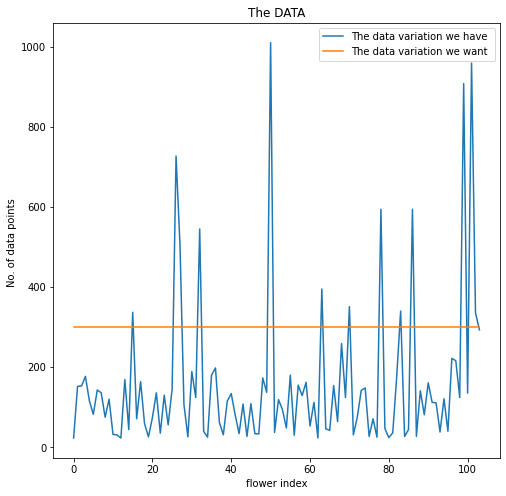

In [ ]:
# lets visualize the data 

# from the list "l" it is cleard thet the data is ""highly biased"" 

# if trained on such data it will make the neural network less robust to the new images 

# for good traning the no of data points for each example should be equal/or near to that 

# let’s decide a common threshold, and make the no. of data points for each sample equal to that threshold 

# lets take the value as mean of  no of samples of the data 

mean = sum(l)/len(l)  # here mean = 150 
 
print("Mean of  no of samples of the data  :: " , mean )
print("\n\n\n\n")

k = list()
for i in range(len(l)):
  k.append(300) # twice of mean   

# ploting the data 

plt.figure(figsize=(8,8))
plt.plot(l , label='The data variation we have ' )
plt.plot(k , label='The data variation we want')
plt.xlabel("flower index")
plt.ylabel("No. of data points ")
plt.title("The DATA")
plt.legend()
plt.show()




In [ ]:
# C) DATA preprocessing 

# From the above figure it is clear that :
# 1) We need to clip the data for the flowers whose data length is above the mean 
# 2) We need to augment the data for the flowers whose data length is below the mean 

In [ ]:
##  IMPORTS ::

import random
from scipy import ndarray

# image processing library for image operations (like image trasnformations .. etc)
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io

import PIL 
from PIL import Image 

# for Image data generation from the directory 

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator





In [ ]:
# Lets create a dictonary which will map the image id to its location in the data set 


img_path = dict()

img_dir = "/content/flower_data/flower_tpu/flower_tpu/flowers_google/flowers_google"

for name in os.listdir(img_dir):
  # load an image from file
  filename =  img_dir + '/' + name

  image_id = name.split('.')[0]

  img_path[image_id] = filename


# print(img_path['2740'])


In [ ]:
# Functions for the data augmentation 


def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray): 
    # add random noise to the image 
    # Adding a random noise to the image for the data augmentation would help to make our Neural Network more robust to the unknown data 
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

# dictionary of the transformations we defined earlier
available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip
}

In [ ]:
# defining the main functions i.e. : "D_aug" ( for data augmentation)  and "D_clip" ( for data clipping ) 

# Return type  :  A list contaning the locations of the images 
import warnings
warnings.simplefilter("ignore")

def get_file_byID(ids):
  l = list()
  for id in ids :
    l.append(img_path[str(id)])
  return l

def D_aug(dataframe , name  , req_length = 300 ):
  #print("in the function D_aug   ::  1  \n")
  ids   = dataframe["id"]   
  imagesf = get_file_byID(ids)

  #print("in the function D_aug   ::  2  \n")



  folder_path = "/content"

  new_img_file = list()
  num_files_desired = req_length - len(dataframe["id"])
 
  num_generated_files = 0

  while num_generated_files <= num_files_desired:
        # random image from the folder
        image_path = random.choice(imagesf)
        # read image as an two dimensional array of pixels
        image_to_transform = sk.io.imread(image_path)
        # random num of transformation to apply
        num_transformations_to_apply = random.randint(1, len(available_transformations))

        num_transformations = 0
        transformed_image = None
        while num_transformations <= num_transformations_to_apply:
            # random transformation to apply for a single image
            key = random.choice(list(available_transformations))
            transformed_image = available_transformations[key](image_to_transform)
            num_transformations += 1
          
        num_generated_files += 1
        new_file_path = '%s/%s_%s.jpg' % (folder_path,  name , num_generated_files)

        new_img_file.append(new_file_path)

        # write image to the disk
        io.imsave(new_file_path, transformed_image)
        #print("done img aug \n")

  return imagesf + new_img_file


def D_clip(dataframe , req_length = 300 ):
  ids   = dataframe["id"]  
  imagesf = get_file_byID(ids)
  final_image_file = list()
  for i in range(req_length):
    final_image_file.append(random.choice(imagesf))
  print("done img clip \n")
  return final_image_file






In [ ]:

import warnings
warnings.simplefilter("ignore")

# lets augment the data to  make the number of examples of each flower type constant (i.e.   lets say : the mean  )
# here we will increase the data size of the flowers whose data length is less than 150  and Decrease the data size of flowers whose data is greater than 150
img_data = dict()
for key in data.keys():
  if len(data[key]) < 150 :
    img_data[key] = D_aug(data[key]  , key , 300 ) 
  else :
    img_data[key] = D_clip(data[key] , 300)  
  
 

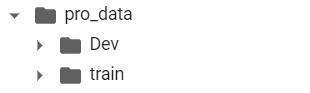

In [ ]:
# lets make two floders train and dev  in the main folder pro_data

# The Train/Test  folder will contain the folders ( of names of flowers )

# and then each folder will have the images of that flowers 

# here is the visual explanation 

from IPython.display import Image
Image("/content/gdrive/My Drive/img2.PNG" )


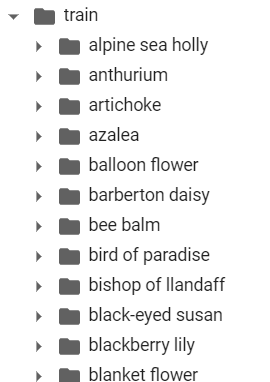

In [ ]:
Image("/content/gdrive/My Drive/img1.PNG" )

In [ ]:

#import shutil 
#shutil.rmtree('/content/pro_data') 

In [ ]:

# Importing Image module from PIL package  
 
from PIL import Image 

os.chdir('/content')

!mkdir pro_data
os.chdir('/content/pro_data')

!mkdir train

os.chdir('./train')


for key in img_data.keys()  :
    
    

    os.mkdir(key)
     
    m =img_data[key][:(int(0.8*len(img_data[key])))]

    os.chdir('/content/pro_data/train/' + str(key))
    for j in range (len(m)):
      # creating a image object (main image)  
      im1 = Image.open(m[j])  
      
      # save a image using extension 
      im1 = im1.save(str(key) + str(j) + ".jpeg") 
    os.chdir('/content/pro_data/train')





In [ ]:

os.chdir('/content/pro_data')

!mkdir Dev

os.chdir('/content/pro_data/Dev')


for key in img_data.keys()  :
    
    

    os.mkdir(key)

    m =img_data[key][(int(0.8*len(img_data[key]))):]

    os.chdir('/content/pro_data/Dev/' + str(key))
    for j in range (len(m)):
      # creating a image object (main image)  
      im1 = Image.open(m[j])  
      
      # save a image using extension 
      im1 = im1.save(str(key) + str(j) + ".jpeg") 
    os.chdir('/content/pro_data/Dev')




In [ ]:


train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
train_generator=train_datagen.flow_from_directory(
'/content/pro_data/train',
target_size=(224,224),
color_mode='rgb',
batch_size=128,
class_mode='categorical',
shuffle=True)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    directory=r"/content/pro_data/Dev",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=128,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 24960 images belonging to 104 classes.
Found 6312 images belonging to 104 classes.


# STEP 2 :: Selecting and Developing an appropriate model 


In [ ]:


# here I have chosen the VGG19 model for this purpose because heavy models are robust and may generalize well  
# the dataset length is good enough to avoid the bias and variance problems  



# IMPORTS 

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D , BatchNormalization
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:

# defining the model 

#import the MobileNetV2  model and discards the last 1000 neuron layer.
base_model=VGG19(include_top=False) 
x=base_model.output
x=GlobalAveragePooling2D()(x)

#we add dense layers so that the model can learn more complex functions and classify for better results

#dense layer 2
x=Dense(512,activation='relu')(x)
x=BatchNormalization()(x)

#dense layer 3
#x=Dense(256,activation='relu')(x)

#final layer with softmax activation
preds=Dense(104,activation='softmax')(x) 

model=Model(inputs=base_model.input,outputs=preds)

In [ ]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

# STEP 3 : : Traning and testing the model on the data 


In [ ]:
step_size_train=train_generator.n//train_generator.batch_size

step_size_test=test_generator.n//test_generator.batch_size



history = model.fit(
    train_generator,
    steps_per_epoch = step_size_train,
    validation_data = test_generator, 
    validation_steps = step_size_test,
    epochs = 5)

Epoch 1/5
195/195 [==============================] - 87s 448ms/step - loss: 1.2561 - accuracy: 0.7225 - val_loss: 1.1292 - val_accuracy: 0.7538
Epoch 2/5
195/195 [==============================] - 87s 447ms/step - loss: 0.3566 - accuracy: 0.9186 - val_loss: 0.6478 - val_accuracy: 0.8340
Epoch 3/5
195/195 [==============================] - 87s 448ms/step - loss: 0.1497 - accuracy: 0.9673 - val_loss: 0.4319 - val_accuracy: 0.8852
Epoch 4/5
195/195 [==============================] - 87s 447ms/step - loss: 0.0552 - accuracy: 0.9906 - val_loss: 0.3913 - val_accuracy: 0.9013
Epoch 5/5
195/195 [==============================] - 87s 448ms/step - loss: 0.0237 - accuracy: 0.9966 - val_loss: 0.3551 - val_accuracy: 0.9173


# conclusion 

The Traning accuracy is good enough 
The testing accuracy is also good (91.7%) but needs some improvement 
